In [1]:
cd ../testing

/media/genesis/work/valjax/testing


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('../config/clean.mplstyle')
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

In [3]:
import jax
jax.config.update('jax_platform_name', 'cpu')
import jax.numpy as np
import pandas as pd
import valjax as vj
import valfunc_interp as vf

In [4]:
# algo params
alg0 = {
    'N': 100, # grid size
    'flo': 0.2, # rel k grid min
    'fhi': 1.5, # rel k grid max
    'ε': 1e-4, # utility cutoff
}

In [5]:
# simple parameters
par0 = {
    'β': 0.95, # discount rate
    'δ': 0.1, # depreciation rate
    'α': 0.35, # capital exponent
    'z': 1.0, # productivity
}

### Interpolated Value

In [13]:
mod = vf.Capital(par0, **alg0)

In [14]:
v1, kp1, ret, hist = mod.j_value_solve(K=300)

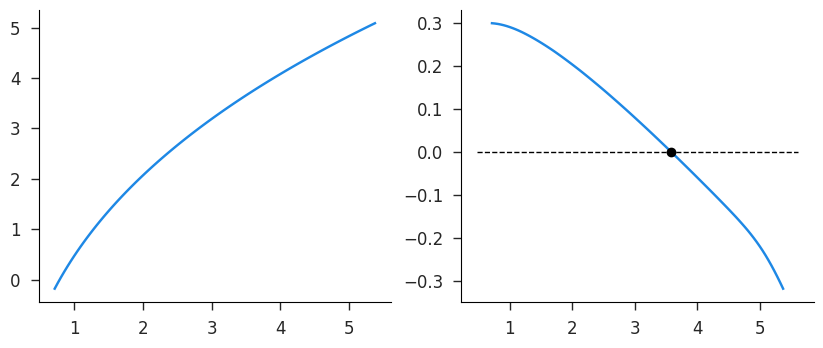

In [15]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 4))
ax0.plot(mod.k_grid, v1)
ax1.plot(mod.k_grid, kp1-mod.k_grid)
ax1.hlines(0, *ax1.get_xlim(), linestyle='--', linewidth=1, color='k');
ax1.scatter(mod.kss, 0, c='k', zorder=10);

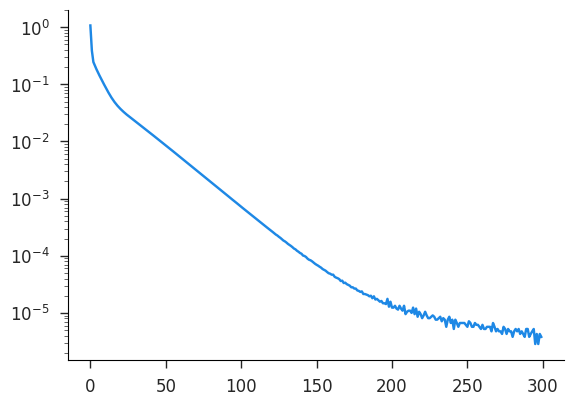

In [16]:
pd.Series(hist['err']).plot(logy=True);

### Spline Test

In [18]:
from functools import partial

In [19]:
d_cubic = jax.grad(vj.cubic_spline_interp, argnums=0)
v_cubic = jax.vmap(partial(vj.cubic_spline_interp, extrap=True), in_axes=(0, None, None))
vd_cubic = jax.vmap(d_cubic, in_axes=(0, None, None))

In [20]:
xlo, xhi, N = 0.0, 1.0, 20
x = np.linspace(xlo, xhi, N)
y, d = x**3, 3*x**2

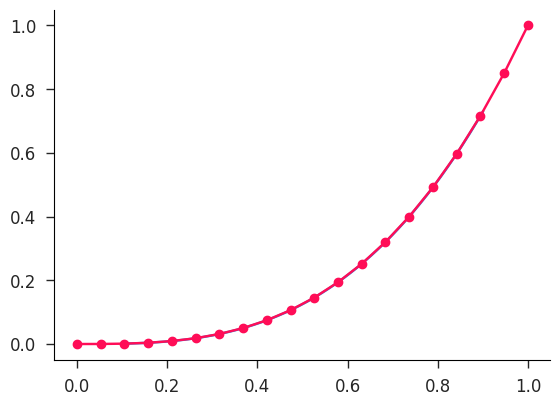

In [21]:
x1 = np.linspace(0.1, 0.9, 1000)
y1 = v_cubic(x1, x, y)
plt.plot(x1, y1);
plt.plot(x, y, marker='o');

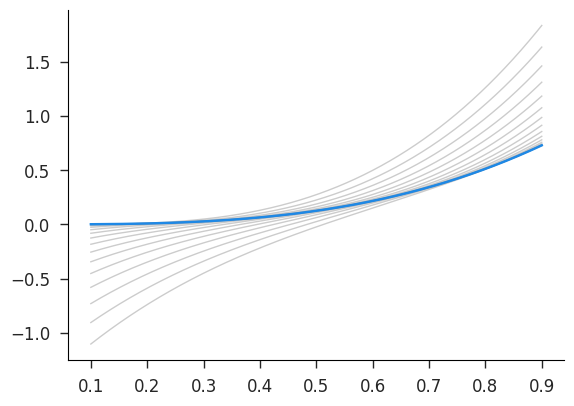

In [22]:
c0, c1, c2, c3 = vj.cubic_spline_fit(x, y)
xlo, xhi = x[:-1], x[1:]
tvec = ((x1[None,:]-xlo[:,None])/(xhi[:,None]-xlo[:,None]))[1:-1,:]
pred = c0[:,None] + c1[:,None]*tvec + c2[:,None]*tvec**2 + c3[:,None]*tvec**3
plt.plot(x1, pred.T, c='gray', linewidth=1, alpha=0.4);
plt.plot(x1, y1);

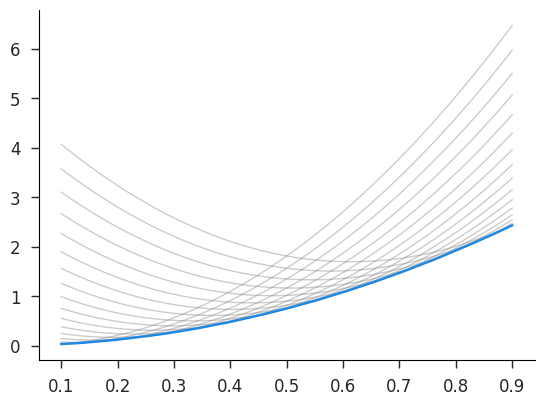

In [25]:
deriv = (c1[:,None] + 2*c2[:,None]*tvec + 3*c3[:,None]*tvec**2)/(xhi[:,None]-xlo[:,None])[1:-1,:]
d1 = vd_cubic(x1, x, y)
plt.plot(x1, deriv.T, c='gray', linewidth=1, alpha=0.4);
plt.plot(x1, d1);